In [1]:
import os
import re
import ast
import glob
import random
import cutlet
import jiwer
import argparse
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from convert_romaji import Romaji2Kana

import pandas as pd
import numpy as np
import seaborn as sns
from sacrebleu.metrics import BLEU, CHRF, TER

from sklearn.model_selection import KFold, train_test_split

import tensorflow as tf

import sentencepiece as spm

from transformers import (
    T5Config,
    T5Tokenizer,
    TFT5ForConditionalGeneration,
    GradientAccumulator,
    logging)

# policy = tf.keras.mixed_precision.Policy('mixed_float16')
# tf.keras.mixed_precision.set_global_policy(policy)

def seed_everything(SEED):
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    print("Random seed set.")

seed_everything(42)
tf.get_logger().setLevel('FATAL')
logging.set_verbosity_error()
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

Random seed set.


# Data Preparation

In [2]:
# katsu = cutlet.Cutlet()
# katsu.use_foreign_spelling = False

# def clean_kanji(sentence):
#     symbols = r"\（.*\）|\(.*\)|\「.*\」|\『.*\』"
#     sentence = re.sub(symbols, "", sentence.strip())
#     return sentence

# def clean_romaji(sentence):
#     sentence = sentence.strip().lower()
#     sentence = re.sub(r"[^a-zA-Z0-9\ ]", "", sentence)
#     sentence = sentence.split()
#     for i, mora in enumerate(sentence):
#         if (mora == "n") | (mora == "u") & (i < len(sentence) - 1):
#             prev_mora = sentence.pop(i-1)
#             sentence[i-1] = "".join([prev_mora, mora])
#     sentence = " ".join(sentence)
#     return sentence

# def kanji2romaji(text):
#     try:
#         new_line = katsu.romaji(text)
#         new_line = clean_romaji(new_line)
#     except:
#         new_line = None
#     return new_line

# def clean_en(sentence):
#     sentence = re.sub(r"\(.*\)|\[.*\]|\{.*\}", "", sentence.strip().lower()) # Parenthesis
#     sentence = re.sub(r"\.{3,}", ",", sentence) # Ellipsis
#     sentence = re.sub(r"[^A-Za-z0-9\ \?\.\!\,\'\"]", "", sentence) # Non alphanumeric
#     return sentence

In [3]:
# main_dir = "D:\School-stuff\Sem-2\PR-Project\HoloASR\Datasets"
# opus_ja_paths = glob.glob(f"{main_dir}\OPUS100-dataset\*.ja")
# tatoeba_ja_paths = glob.glob(f"{main_dir}\Tatoeba-dataset\*.ja")

# ja_paths = opus_ja_paths + tatoeba_ja_paths + coursera_ja_paths

# ja_lines, en_lines = [], []
# for ja_path in ja_paths:
#     if ja_path.endswith(".ja"):
#         en_path = ja_path.rsplit(".", 1)[0] + ".en"
#     else:
#         en_path = ja_path.replace("ja", "en")
#     with open(ja_path, "r", encoding="utf-8") as f:
#         lines = [line.strip("\n") for line in f.readlines()]
#         ja_lines.extend(lines)
#     with open(en_path, "r", encoding="utf-8") as f:
#         lines = [line.strip("\n") for line in f.readlines()]
#         en_lines.extend(lines)

# tqdm.pandas()
# data = pd.DataFrame({'ja_raw': ja_lines, 'en': en_lines})
# data['ja_raw'] = data['ja_raw'].progress_apply(clean_kanji)
# data['ja_ro'] = data['ja_raw'].progress_apply(kanji2romaji)
# data = data.dropna().reset_index(drop=True)
# data['ja_hira'] = data['ja_ro'].progress_apply(Romaji2Kana)
# data['en'] = data['en'].progress_apply(clean_en)
# data = data.dropna().reset_index(drop=True)
# data.to_csv(
#     r"E:\Datasets\Language_model\tokenizer_text.csv",
#     index=False, encoding="utf-8")
# data

In [4]:
# data = pd.read_csv(r"E:\Datasets\Language_model\tokenizer_text.csv")
# data = data.dropna().reset_index(drop=True)[['en', 'ja_hira']]

# with open(r"E:\Datasets\Language_model\tokenizer_text.txt", "w", encoding="utf-8") as f:
#     for row in tqdm(data.iterrows(), total=len(data)):
#         idx, (en, ja) = row
#         row =  " ".join([en, ja]) + "\n"
#         f.write(row)

In [5]:
# text_file = r"E:\Datasets\Language_model\tokenizer_text.txt"
# model_prefix = r"E:\Datasets\Language_model\t5_spm"

# spm.SentencePieceTrainer.train(
#     f"--input={text_file} --model_prefix={model_prefix} --vocab_size={32128} --model_type=unigram --pad_id=0 --unk_id=2 --bos_id=-1 --eos_id=1 --pad_piece=<pad> --unk_piece=<unk> --eos_piece=</s>"
# )

# Data Loading

In [6]:
class TFRWriter():
    def __init__(self):
        self.main_dir = "E://Datasets/Language_model"
        self.n_shards = 10
        self.tokenizer = T5Tokenizer(
            vocab_file=f"{self.main_dir}/t5_spm.model",
            eos_token="</s>",
            unk_token="<unk>",
            pad_token="<pad>")
        self.data = self.get_data()

    def get_data(self):
        tqdm.pandas()
        data = pd.read_csv(
            f"{self.main_dir}/tokenizer_text.csv", 
            encoding="utf-8")
        data = data.dropna().reset_index(drop=True)[['en', 'ja_hira']]
        data['ja_token'] = data['ja_hira'].progress_apply(
            lambda x: self.tokenizer(x).input_ids)
        data['en_token'] = data['en'].progress_apply(
            lambda x: self.tokenizer(x).input_ids)
        data['ja_len'] = data['ja_token'].apply(len)
        data = data.query(f"ja_len >= 4 & ja_len <= 21")
        data = data.sort_values(by="ja_len", ignore_index=True, ascending=True)
        data.to_csv(
            f"{self.main_dir}/tokenizer_text2.csv",
            index=False)
        return data

    def _bytes_feature(self, value):
        """Returns a bytes_list from a string / byte."""
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    def serialize_example(self, *args):
        feature = {
            'input_ids': self._bytes_feature(args[0]),
            'attention_mask': self._bytes_feature(args[1]),
            'labels': self._bytes_feature(args[2])}

        example_proto = tf.train.Example(
            features=tf.train.Features(feature=feature))
        return example_proto.SerializeToString()

    def get_shards(self):
        skf = KFold(n_splits=self.n_shards, shuffle=False)
        return [j for i,j in skf.split(self.data)]

    def get_shard_data(self, samples):
        for sample in samples:
            input_ids = tf.convert_to_tensor(
                self.data['ja_token'][sample], dtype=tf.int32)
            attention_mask = tf.where(input_ids != 0, x=1, y=0)
            labels = tf.convert_to_tensor(
                self.data['en_token'][sample], dtype=tf.int32)
            yield {
                "input_ids": tf.io.serialize_tensor(input_ids),
                "attention_mask": tf.io.serialize_tensor(attention_mask),
                "labels": tf.io.serialize_tensor(labels)}

    def write(self):
        for shard, samples in tqdm(enumerate(self.get_shards()), total=self.n_shards):
            with tf.io.TFRecordWriter(f"{self.main_dir}/t5_tfrec/shard_{shard+1}.tfrec") as f:
                for sample in self.get_shard_data(samples):
                    example = self.serialize_example(
                        sample['input_ids'],
                        sample['attention_mask'],
                        sample['labels'])
                    f.write(example)

# TFRWriter().write()

In [7]:
def ArgParser():
    parser = argparse.ArgumentParser()

    parser.add_argument("--random_state", default=42)
    parser.add_argument("--main_dir", default="E://Datasets/Language_model")
    parser.add_argument("--n_shards", default=10)
    parser.add_argument("--test_size", default=0.1)
    parser.add_argument("--batch_size", default=32)
    parser.add_argument("--buffer_size", default=512)

    # Trainer
    parser.add_argument("--accum_steps", default=1)

    # Scheduler
    parser.add_argument("--epochs", default=15)
    parser.add_argument("--learning_rate", default=3e-4)
    parser.add_argument("--lr_start", default=1e-8)
    parser.add_argument("--lr_min", default=1e-8)
    parser.add_argument("--lr_max", default=3e-4)
    parser.add_argument("--n_cycles", default=0.5)
    parser.add_argument("--warmup_epochs", default=0)
    parser.add_argument("--sustain_epochs", default=2)

    args = parser.parse_known_args()[0]

    n_samples = len(pd.read_csv(
        f"{args.main_dir}/tokenizer_text2.csv"))   

    n_train = int(n_samples * (1 - args.test_size))
    n_val = int(n_samples * args.test_size)
    train_steps = int(np.ceil(n_train / args.batch_size))
    val_steps = int(np.ceil(n_val / args.batch_size))
        
    parser.add_argument("--n_samples", default=n_samples)
    parser.add_argument("--n_train", default=n_train)
    parser.add_argument("--n_val", default=n_val)
    parser.add_argument("--train_steps", default=train_steps)  
    parser.add_argument("--val_steps", default=val_steps)

    return parser.parse_known_args()[0]

args = ArgParser()
args

Namespace(accum_steps=1, batch_size=32, buffer_size=512, epochs=15, learning_rate=0.0003, lr_max=0.0003, lr_min=1e-08, lr_start=1e-08, main_dir='E://Datasets/Language_model', n_cycles=0.5, n_samples=1034384, n_shards=10, n_train=930945, n_val=103438, random_state=42, sustain_epochs=2, test_size=0.1, train_steps=29093, val_steps=3233, warmup_epochs=0)

In [8]:
class DataLoader:
    def __init__(self, args):
        self.files = glob.glob(args.main_dir + "/t5_tfrec/*.tfrec")
        self.args = args
        self.AUTOTUNE = tf.data.AUTOTUNE
        self.train_files, self.val_files = train_test_split(
            self.files, test_size=args.test_size, shuffle=True, 
            random_state=args.random_state)
        self.train = self.get_train()
        self.val = self.get_val()

    def read_tfrecord(self, example):
        feature_description = {
            'input_ids': tf.io.FixedLenFeature([], tf.string),
            'attention_mask': tf.io.FixedLenFeature([], tf.string),
            'labels': tf.io.FixedLenFeature([], tf.string)
            }
        
        example = tf.io.parse_single_example(example, feature_description)
        example['input_ids'] = tf.io.parse_tensor(
            example['input_ids'], out_type=tf.int32)
        example['attention_mask'] = tf.io.parse_tensor(
            example['attention_mask'], out_type=tf.int32) 
        example['labels'] = tf.io.parse_tensor(
            example['labels'], out_type=tf.int32)
        return example

    def load_dataset(self, files):
        ignore_order = tf.data.Options()
        ignore_order.experimental_deterministic = False
        dataset = tf.data.TFRecordDataset(files)
        dataset = dataset.with_options(ignore_order)
        dataset = dataset.map(self.read_tfrecord, num_parallel_calls=self.AUTOTUNE)
        return dataset

    def get_train(self):
        dataset = self.load_dataset(self.train_files)
        dataset = dataset.padded_batch(
            self.args.batch_size,
            padded_shapes={
                'input_ids': [None],
                'attention_mask': [None],
                'labels': [None]
            },
            padding_values={
                'input_ids': tf.constant(0, dtype=tf.int32),
                'attention_mask': tf.constant(0, dtype=tf.int32),
                'labels': tf.constant(-100, dtype=tf.int32)
            })        
        dataset = dataset.shuffle(self.args.buffer_size)
        dataset = dataset.prefetch(self.AUTOTUNE)
        return dataset

    def get_val(self):
        dataset = self.load_dataset(self.val_files)
        dataset = dataset.padded_batch(
            self.args.batch_size,
            padded_shapes={
                'input_ids': [None],
                'attention_mask': [None],
                'labels': [None]
            },
            padding_values={
                'input_ids': tf.constant(0, dtype=tf.int32),
                'attention_mask': tf.constant(0, dtype=tf.int32),
                'labels': tf.constant(-100, dtype=tf.int32)
            })
        dataset = dataset.shuffle(self.args.buffer_size)
        dataset = dataset.cache()
        dataset = dataset.prefetch(self.AUTOTUNE)
        return dataset

# train = DataLoader(args).train

# inputs = next(iter(train))
# input_values = inputs['input_ids']
# labels = inputs['labels']
# attention_mask = inputs['attention_mask']
# print(inputs)

# Model Training

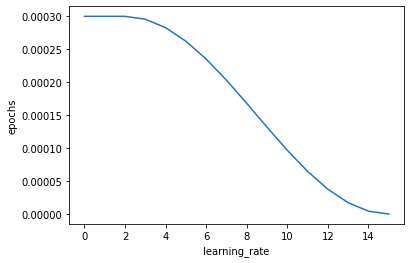

In [9]:
class BLEUMetric(tf.keras.metrics.Metric):
    def __init__(self, name="BLEU", **kwargs):
        super(BLEUMetric, self).__init__(name=name, **kwargs)
        self.bleu = BLEU()
        self.accumulator = self.add_weight(name="total_bleu", initializer="zeros")
        self.counter = self.add_weight(name="counter", initializer="zeros")
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        try:
            bleu_score = self.bleu.corpus_score(hypotheses=y_true, references=y_pred).score
        except:
            y_pred = ["." if x == "" else x for x in y_pred]
            bleu_score = self.bleu.corpus_score(hypotheses=y_true, references=y_pred).score
        self.accumulator.assign_add(bleu_score)
        self.counter.assign_add(1)

    def result(self):
        return tf.math.divide_no_nan(self.accumulator, self.counter)

    def reset_states(self):
        self.accumulator.assign(0.0)
        self.counter.assign(0.0)

class WERMetric(tf.keras.metrics.Metric):
    def __init__(self, name="WER", **kwargs):
        super(WERMetric, self).__init__(name=name,  **kwargs)
        self.accumulator = self.add_weight(name="total_wer", initializer="zeros")
        self.counter = self.add_weight(name="wer_count", initializer="zeros")    

    def update_state(self, y_true, y_pred, sample_weight=None):
        wer = jiwer.wer(y_true, y_pred)

        # Add distance and number of batches to variables
        self.accumulator.assign_add(wer)
        self.counter.assign_add(1)

    def result(self):
        # Divides accumulated distance scores against number of batches passed,
        # mimics mean reduction over batch
        return tf.math.divide_no_nan(self.accumulator, self.counter)   
    
    def reset_states(self):
        self.accumulator.assign(0.0)
        self.counter.assign(0.0)

class CosineDecayWithWarmup(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, args):
        self.args = args

    def __call__(self, epoch):  
        if epoch < self.args.warmup_epochs:
            lr = ((self.args.lr_max - self.args.lr_start) / self.args.warmup_epochs) * epoch + self.args.lr_start
        elif epoch < (self.args.warmup_epochs + self.args.sustain_epochs):
            lr = self.args.lr_max
        else:
            progress = ((epoch - self.args.warmup_epochs - self.args.sustain_epochs) / 
            (self.args.epochs - self.args.warmup_epochs - self.args.sustain_epochs))
            lr = (self.args.lr_max-self.args.lr_min) * (0.5 * (1.0 + tf.math.cos((22/7) * 
                self.args.n_cycles * 2.0 * progress)))
            if self.args.lr_min is not None:
                lr = tf.math.maximum(self.args.lr_min, lr)
        return lr

    def plot(self):
        epochs = range(self.args.epochs+1)
        lr = [self(epoch) for epoch in epochs]
        plt.plot(epochs, lr)
        plt.xlabel("learning_rate")
        plt.ylabel("epochs")
        plt.show()

CosineDecayWithWarmup(args).plot()

In [10]:
class Trainer:
    def __init__(self, args):
        self.args = args
        self.tokenizer = T5Tokenizer(
            vocab_file=f"{self.args.main_dir}/t5_spm.model",
            extra_ids=0,
            eos_token="</s>",
            unk_token="<unk>",
            pad_token="<pad>")
        self.train_dataset = DataLoader(args).train
        self.val_dataset = DataLoader(args).val
        schedule = CosineDecayWithWarmup(args)
        self.optimizer = tf.keras.optimizers.Adam(schedule)
        self.bleu_metric = BLEUMetric()
        self.wer_metric = WERMetric()
        self.gradient_accumulator = GradientAccumulator()
        self.gradient_accumulator.accum_steps = args.accum_steps
        
        # self.model = TFT5ForConditionalGeneration.from_pretrained(
        #     "t5-small",
        #     pad_token_id=0,
        #     eos_token_id=1,
        #     vocab_size=len(self.tokenizer),
        #     decoder_start_token_id=0,
        #     output_hidden_states=False,
        #     output_attentions=False,
        #     use_cache=False)
        
        self.model = TFT5ForConditionalGeneration(config=T5Config(
            pad_token_id=0,
            eos_token_id=1,
            decoder_start_token_id=0,
            vocab_size=len(self.tokenizer),
            output_hidden_states=False,
            output_attentions=False,
            use_cache=False
        ))

        self.model_name = f"model_{int(self.args.n_samples/1000)}k"
        self.log_path = f"{self.args.main_dir}/model_weights/{self.model_name}.csv"
        if not os.path.exists(self.log_path):
            print("Log file created.")
            columns = "epoch,loss,bleu,wer,val_loss,val_bleu,val_wer\n"
            with open(self.log_path, "a") as f:
                f.write(columns)

    def decoder(self, labels, logits):
        labels = tf.where(labels < 0, x=0, y=labels)
        labels = self.tokenizer.batch_decode(labels, skip_special_tokens=True)  
        logits = tf.argmax(logits, axis=-1)
        logits = self.tokenizer.batch_decode(logits, skip_special_tokens=True)
        return labels, logits

    def display(self, epoch, t_labels, t_logits, v_labels, v_logits):
        print("-" * 129)
        print("Training")
        for y_true, y_pred in zip(t_labels, t_logits):
            print(f"Target:    {y_true}")
            print(f"Predicted: {y_pred}") 

        print("\nValidation")
        for y_true, y_pred in zip(v_labels, v_logits):
            print(f"Target:    {y_true}")
            print(f"Predicted: {y_pred}")
        print("-" * 129)
        
    def fit(self):
        # Checkpointing
        self.ckpt_dir = f"{self.args.main_dir}/checkpoints"
        self.ckpt = tf.train.Checkpoint(self.model)
        self.ckpt_manager = tf.train.CheckpointManager(
            checkpoint=self.ckpt, directory=self.ckpt_dir, max_to_keep=5)

        if self.ckpt_manager.latest_checkpoint:
            self.start_epoch = int(self.ckpt_manager.latest_checkpoint.split("-")[-1])
            self.ckpt.restore(self.ckpt_manager.latest_checkpoint)
            print(f"Resuming from epoch {self.start_epoch + 1}...")
        else:
            self.start_epoch = 0
            print("Starting from epoch 1...")

        for epoch in range(self.args.epochs):
            print(f"Epoch {epoch+1}/{self.args.epochs}: Learning rate @ {self.optimizer.lr(epoch):.2e}")
            stateful_metrics = ["loss", "bleu", "wer", "val_loss", "val_bleu", "val_wer"]
            progbar = tf.keras.utils.Progbar(
                self.args.train_steps, interval=0.05,
                stateful_metrics=stateful_metrics)

            # Training loop
            for step, t_batch in enumerate(self.train_dataset):
                with tf.GradientTape() as tape:
                    t_loss, t_logits = self.model(
                        input_ids=t_batch['input_ids'],
                        attention_mask=t_batch['attention_mask'],
                        labels=t_batch['labels'],
                        training=True)[:2]              
                self.gradient_accumulator(tape.gradient(t_loss, self.model.trainable_weights))
                self.optimizer.apply_gradients(zip(
                    self.gradient_accumulator.gradients, 
                    self.model.trainable_weights))
                t_labels, t_logits = self.decoder(t_batch['labels'], t_logits)
                self.bleu_metric.update_state(t_labels, t_logits)
                self.wer_metric.update_state(t_labels, t_logits)
                t_bleu = self.bleu_metric.result()
                t_wer = self.wer_metric.result()
                t_values = [
                    ("loss", tf.reduce_mean(t_loss)),
                    ("bleu", t_bleu),
                    ("wer", t_wer)]
                progbar.update(step, values=t_values, finalize=False)
            self.bleu_metric.reset_states()
            self.wer_metric.reset_states()

            # Validation loop
            for v_batch in self.val_dataset:
                v_loss, v_logits = self.model(
                    input_ids=v_batch['input_ids'],
                    attention_mask=v_batch['attention_mask'],
                    labels=v_batch['labels'],
                    training=False)[:2]
                v_labels, v_logits = self.decoder(v_batch['labels'], v_logits)
                self.bleu_metric.update_state(v_labels, v_logits)
                self.wer_metric.update_state(v_labels, v_logits)
            
            v_bleu = self.bleu_metric.result()
            v_wer = self.wer_metric.result()
            v_values = [
                ("loss", tf.reduce_mean(t_loss)), 
                ("bleu", t_bleu),
                ("wer", t_wer),
                ("val_loss", tf.reduce_mean(v_loss)),
                ("val_bleu", v_bleu),
                ("val_wer", v_wer)]
            progbar.update(self.args.train_steps, values=v_values, finalize=True)
            self.bleu_metric.reset_states()
            self.wer_metric.reset_states()

            # Print sample transcriptions for both loops
            self.display(epoch, t_labels, t_logits, v_labels, v_logits)

            # Checkpointing
            self.ckpt.save(file_prefix=f"{self.ckpt_dir}/{self.model_name}")

            # Logging
            log = f"{epoch+1},{t_loss},{t_bleu},{t_wer},{v_loss},{v_bleu},{v_wer}\n"
            with open(self.log_path, "a") as f:
                f.write(log)

            save_path = f"{self.args.main_dir}/model_weights"
            self.model.save_weights(f"{save_path}/{self.model_name}_{epoch+1}.h5")

Trainer(args).fit()

Starting from epoch 1...
Epoch 1/15: Learning rate @ 3.00e-04
  823/29093 [..............................] - ETA: 16:14:44 - loss: 6.7312 - bleu: 0.3136 - wer: 1.0017